In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GB, 
    GradientBoostingClassifier as GC)
from ISLP.bart import BART
import sklearn.model_selection as skm
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import networkx as nx
import graphviz
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [3]:
data = pd.read_pickle("data.pkl")

In [5]:
### MAIN DAG ###
dag4 = """graph [
directed 1

node [
    id 0
    label "Callback"
    ]

node [
    id 1
    label "Controls"
    ]

node [
    id 2
    label "Female"
    ]

node [
    id 3
    label "Public Role"
    ]

node [
    id 4
    label "Type"
    ]

node [
    id 5
    label "Discrimination"
    ]

node [
    id 6
    label "Unobserved Job Factors"
    ]

edge [
    source 1
    target 5
    ]

edge [
    source 2
    target 5
    ]

edge [
    source 3
    target 5
    ]

edge [
    source 4
    target 5
    ]

edge [
    source 5
    target 0
    ]

edge [
    source 1
    target 0
    ]

edge [
    source 2
    target 0
    ]

edge [
    source 3
    target 0
    ]

edge [
    source 4
    target 0
    ]

edge [
    source 6
    target 3
    ]

edge [
    source 6
    target 0
    ]

]
"""


C:\Users\agonz\AppData\Local\Temp\ipykernel_37588\2254515697.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


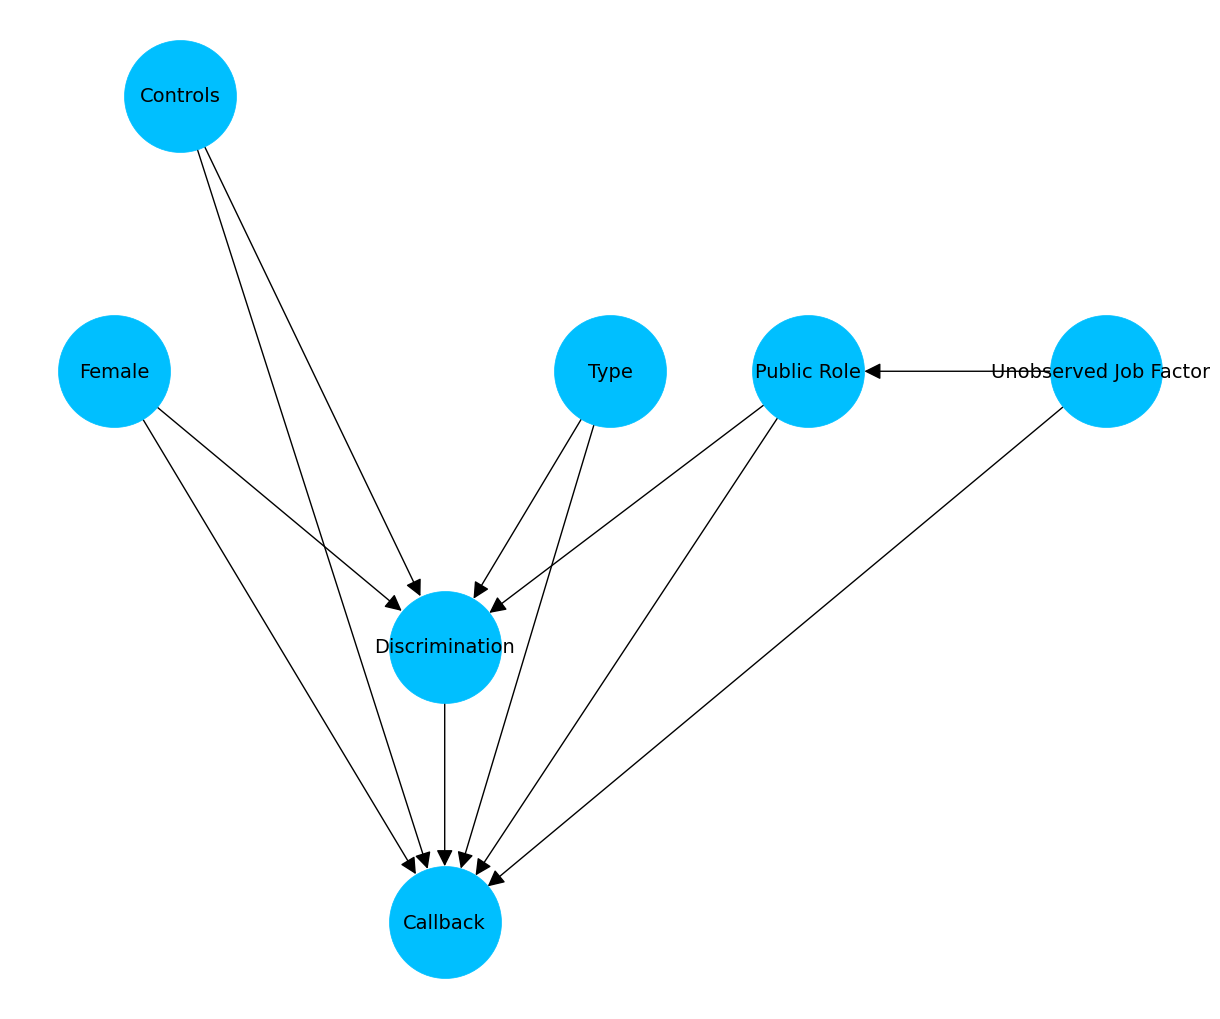

In [11]:
###PLOT
graph4 = nx.parse_gml(dag4)

pos4 = {
    "Controls": (-0.8, 3), 
    "Female": (-1, 2),
    "Public Role": (1.1, 2),
    "Type": (0.5, 2),        
    "Discrimination": (0, 1),
    "Unobserved Job Factors": (2, 2),
    "Callback": (0, 0)
}

plt.figure(figsize=(12, 10))
nx.draw(
    graph4,
    pos4,
    with_labels=True,
    node_size=6500,
    node_color='deepskyblue',
    font_color='black',
    font_size=14,
    arrows=True,
    arrowsize=25
)
plt.tight_layout()
plt.savefig("DAG4.png")
plt.show()
